# Application Example
## IMDB Movie-review Sentiment Prediction
### Introduction
We are going to _restrict moview reviews_ to the __top 10000 most common words__ and _cut off reviews_ after 
only __20 words__. The network will learn 8-dimensional embeddings for each of the 10000 words, turn the input 
integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, 
and train a single Dense layer on top for classification.

In [1]:
# Loading the IMDB data for use with an Embedding layer
from keras.datasets import imdb
from keras.utils import pad_sequences

In [2]:
max_features = 10000
maxlen = 20

# Load the data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)

# Pad the sequences
x_train = pad_sequences(x_train, maxlen = maxlen)
x_test = pad_sequences(x_test, maxlen = maxlen)

17464789/17464789 [==============================] - 0s 0us/step


In [3]:
# Using an Embedding layer and classifier on the IMDB data
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length = maxlen))
model.add(Flatten())
model.add(Dense(1, activation = "sigmoid"))
model.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 8)             80000     
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 1)                 161       
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [4]:
history = model.fit(x_train, y_train, epochs = 10, batch_size = 32, 
                   validation_split = 0.2)

Epoch 1/10
625/625 [==============================] - 2s 3ms/step - loss: 0.6775 - accuracy: 0.5974 - val_loss: 0.6385 - val_accuracy: 0.6810
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5586 - accuracy: 0.7433 - val_loss: 0.5346 - val_accuracy: 0.7256
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4709 - accuracy: 0.7822 - val_loss: 0.5047 - val_accuracy: 0.7442
Epoch 4/10
625/625 [==============================] - 2s 2ms/step - loss: 0.4285 - accuracy: 0.8045 - val_loss: 0.4970 - val_accuracy: 0.7542
Epoch 5/10
625/625 [==============================] - 2s 2ms/step - loss: 0.4000 - accuracy: 0.8224 - val_loss: 0.4965 - val_accuracy: 0.7558
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3766 - accuracy: 0.8336 - val_loss: 0.4979 - val_accuracy: 0.7550
Epoch 7/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3565 - accuracy: 0.8479 - val_loss: 0.5035 - val_accuracy: 0.7526
Epoch 

### Analysis
A validation accuracy of 74% is achieved which is pretty good considering we are looking at least first 20 words
 in every review.

#### NOTE
Merely flattening the embedded sequences and training a single Dense layer on top leads to a model that treats each 
word in the input sequences separately, without considering inter-word relationships and sentence structure.  
It is much better to add recurrent layers or one dimensional convolutional layers on top of the embedded sequences 
to learn features that take into account each sequence as a whole.

### Using Pretrained Word Embeddings
This is useful when one has little data. We load embedded vectors from a precomputed embedding space that is highly 
structured and exhibits useful properties - that captures the generic aspects of language structure.  
Such word-embeddings are generally computed using word-occurence statistics, using a variety of techniques, some 
involving neural networks, others not.

#### Examples of Pre-computed databases of word embedding available for download and use in a Keras embedding layer
- Word2vec - by Tomas Mikolov at Google in 2013
    - It's dimensions capture specific semantic properties, such as gender.
- Global Vectors for Word Representation (GloVe) - by stanford researchers in 2014
    - It is based on a factoring matrix of word co-occurrence statistics.
    
#### Putting it all together from raw text to word embeddings
__Link:__ http://mng.bz/0tIo  
Download raw IMDB dataset; uncompress it; collect the individual training reviews into a list of strings - one 
string per reviews.

In [5]:
# Processing the labels of the raw IMDB data
import os
imdb_dir = '/kaggle/input/imdb-dataset/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname))
        texts.append(f.read())
        f.close()
        if label_type == "neg":
            labels.append(0)
        else:
            labels.append(1)

In [6]:
# Tokenizing the data
from keras.preprocessing.text import Tokenizer
import numpy as np

# Cut off reviews after 100 words
max_len = 100

# Train on 200 samples
training_samples = 200

# Validation 10000 samples
validation_samples = 10000

# Consider only the top 10000 words in dataset
max_words = 10000

In [7]:
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

data = pad_sequences(sequences, maxlen = maxlen)
labels = np.asarray(labels)
print("Shape of data tensor: ", data.shape)
print("Shape of label tensor: ", labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples : training_samples + validation_samples]
y_val = labels[training_samples : training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor:  (25000, 20)
Shape of label tensor:  (25000,)


#### Downloading the GloVe Word Embeddings
__Link:__ https://nlp.stanford.edu/projects/glove/  
The GloVe word embeddings contains 100-dimensional embedding vectors for 400000 words (or tokens). We shall build an embedded matrix that we can load into an Embedded layer. It must be a matrix of __shape (max_words, embedding_dim)__, where each entry _i_ contains the embeddind_dim-dimensional vector for the word of index _i_ in the reference word index (built during tokenization.)

##### NOTE
Index 0 isn't supposed to stand for any word or token - it is a placeholder.

In [8]:
# Parsing the GloVe word-embeddings file
glove_dir = "/kaggle/input/glove-embeddings"
embeddings_index = {}
f = open(os.path.join(glove_dir, "glove.6B.100d.txt"))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = "float32")
    embeddings_index[word] = coefs
f.close()
print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [9]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [10]:
#  Defining the model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(32, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 100)           1000000   
                                                                 
 flatten_1 (Flatten)         (None, 2000)              0         
                                                                 
 dense_1 (Dense)             (None, 32)                64032     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,064,065
Trainable params: 1,064,065
Non-trainable params: 0
_________________________________________________________________


The Embedding layer has a single weight matrix: a 2D float matrix where each entry is a word vector meant to be 
associated with the index _i_.

When parts of a model are pretrained (like the Embeddings layer) and parts are randomly initialized (like the 
classifier), the pretrained parts shouldn't be updated during training, to avoid forgetting what they already know.  
The large gradient updates triggered by the randomly initialized layers would be disruptive to the already-learned 
features.

In [11]:
# Loading pretrained word embeddings into the Embedding Layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# Training and evaluating the model
model.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"])
history = model.fit(x_train, y_train, epochs = 10, batch_size = 32, 
                   validation_data = (x_val, y_val))
model.save_weights("pretrained_glove_model.h5")

Epoch 1/10
7/7 [==============================] - 1s 140ms/step - loss: 0.8359 - accuracy: 0.5100 - val_loss: 0.7473 - val_accuracy: 0.5236
Epoch 2/10
7/7 [==============================] - 1s 97ms/step - loss: 0.6199 - accuracy: 0.6300 - val_loss: 0.7027 - val_accuracy: 0.5458
Epoch 3/10
7/7 [==============================] - 1s 95ms/step - loss: 0.4595 - accuracy: 0.8200 - val_loss: 0.8404 - val_accuracy: 0.5262
Epoch 4/10
7/7 [==============================] - 1s 99ms/step - loss: 0.3797 - accuracy: 0.8850 - val_loss: 0.9354 - val_accuracy: 0.5217
Epoch 5/10
7/7 [==============================] - 1s 107ms/step - loss: 0.2947 - accuracy: 0.9350 - val_loss: 0.7407 - val_accuracy: 0.5518
Epoch 6/10
7/7 [==============================] - 1s 97ms/step - loss: 0.2175 - accuracy: 0.9700 - val_loss: 0.7489 - val_accuracy: 0.5488
Epoch 7/10
7/7 [==============================] - 1s 98ms/step - loss: 0.1880 - accuracy: 0.9800 - val_loss: 1.3315 - val_accuracy: 0.5143
Epoch 8/10
7/7 [=========

{'loss': [0.835896372795105, 0.6198513507843018, 0.4595155417919159, 0.37971270084381104, 0.2946861982345581, 0.21749524772167206, 0.18800324201583862, 0.17064154148101807, 0.1238129585981369, 0.11296801269054413], 'accuracy': [0.5099999904632568, 0.6299999952316284, 0.8199999928474426, 0.8849999904632568, 0.9350000023841858, 0.9700000286102295, 0.9800000190734863, 0.9599999785423279, 1.0, 1.0], 'val_loss': [0.7473263740539551, 0.7026757597923279, 0.8403744101524353, 0.9354287981987, 0.7406661510467529, 0.748869776725769, 1.3314614295959473, 0.7867664098739624, 0.9325101375579834, 1.0740482807159424], 'val_accuracy': [0.5235999822616577, 0.545799970626831, 0.526199996471405, 0.5217000246047974, 0.551800012588501, 0.548799991607666, 0.5142999887466431, 0.5521000027656555, 0.5425000190734863, 0.535099983215332]}


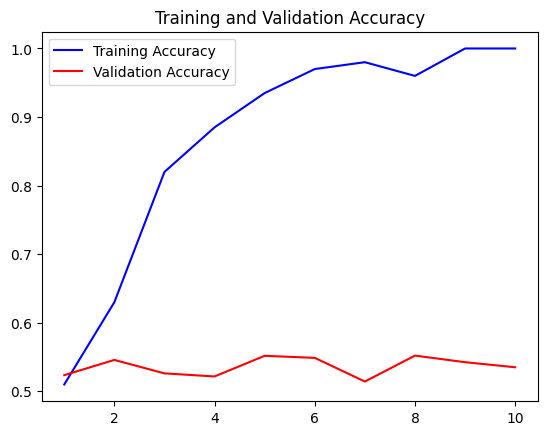

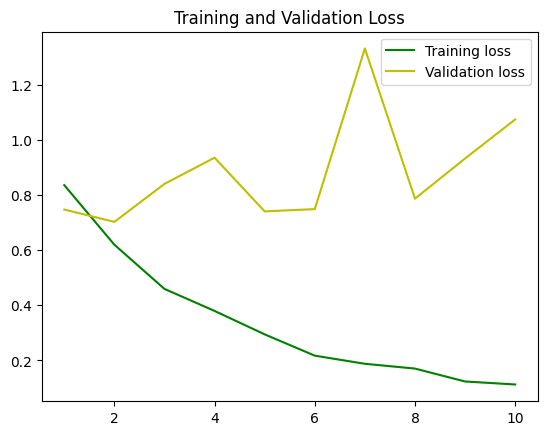

In [12]:
# Plotting the results
import matplotlib.pyplot as plt

print(history.history)
accuracy = history.history["accuracy"]
validation_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
validation_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "b", label = "Training Accuracy")
plt.plot(epochs, validation_accuracy, "r", label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "g", label = "Training loss")
plt.plot(epochs, validation_loss, "y", label = "Validation loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


## Training the same model without pretrained word embeddings

In [13]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(32, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))
model.summary()

model.compile(optimizer = "rmsprop", loss = "binary_crossentropy", 
              metrics = ["accuracy"])
history = model.fit(x_train, y_train, epochs = 10, batch_size = 32, 
                   validation_data = (x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 100)           1000000   
                                                                 
 flatten_2 (Flatten)         (None, 2000)              0         
                                                                 
 dense_3 (Dense)             (None, 32)                64032     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,064,065
Trainable params: 1,064,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 1s 132ms/step - loss: 0.6930 - accuracy: 0.5000 - val_loss: 0.6926 - val_accuracy: 0.5155
Epoch 2/10
7/7 [====================

In [14]:
# Tokenizing the data on the test set
test_dir = os.path.join(imdb_dir, "test")
labels = []
texts = []
for label_type in ["neg", "pos"]:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == ".txt":
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == "neg":
                labels.append(0)
            else:
                labels.append(1)
                
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen = maxlen)
y_test = np.asarray(labels)

In [15]:
# Evaluating the model on the test data
model.load_weights("pretrained_glove_model.h5")
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 1.0808 - accuracy: 0.5270


[1.0807952880859375, 0.526960015296936]

Validation accuracy stalls at 53%. So in this case, pretrained word embeddings
outperform jointly learned embeddings. If we increase the number of training samples, this will increase the accuracy drastically.